In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
# from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

In [46]:
# import os
# import glob
# #delete all pkl files in a folder
# def delete_pkl_files(folder_path):
#     pkl_pattern = os.path.join(folder_path, '**', '*.pkl')
#     pkl_files = glob.glob(pkl_pattern, recursive=True)

#     for pkl_file in pkl_files:
#         try:
#             os.remove(pkl_file)
#             print(f"Deleted: {pkl_file}")
#         except OSError as e:
#             print(f"Error deleting {pkl_file}: {e}")

# folder_path = 'C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS_waterFutures/results'  
# delete_pkl_files(folder_path)

# spot market water price

In [2]:
# Initialize total acreage for each crop
total_acres_almond = (21.385 + 7.175 + 8.042) * 1000.0
total_acres_pistachio = (12.060 + 13.685 + 13.72) * 1000.0

# Initialize cost and revenue from agricultural production
# Immature pistachios (by year of immaturity)
cost_per_acre_pistachio = [3469, 822, 968, 1071, 1394, 1794]
revenue_per_acre_pistachio = [0, 0, 0, 0, 0, 1272]
immature_acres_pistachio = np.zeros(6)

# Mature pistachios
mature_operating_costs_pistachio = 3210
mature_revenues_pistachio = 5997

# Immature almonds
cost_per_acre_almond = [6565, 1462, 2358, 3171, 3691]
revenue_per_acre_almond = [0, 0, 600, 1200, 2400]
immature_acres_almond = np.ones(5) * total_acres_almond / 25.0

# Mature almonds
mature_operating_costs_almond = 3987
mature_revenues_almond = 7500

# Almonds stop being productive after 25 years
acres_by_year_almond = np.ones(25) * total_acres_almond / 25.0

In [34]:
##Estimation of future contract price
##based on weighted average of water shortfall for all scenarios
water_price_data = pd.read_csv("water_index_predictions.csv", parse_dates=["Date"])
water_price_data.set_index("Date", inplace=True)

price_dates = ['2025-06-30', '2026-06-30', '2027-06-30']
price_dates = pd.to_datetime(price_dates)

acre_feet_per_contract = 10  # One contract represents 10 acre-feet
fees = 2.25*2  # Fees for futures and futures options are $2.251 per contract, plus exchange and regulatory fees (assumed to be $2.25 per contract)

total_shortfall_by_year = np.zeros(3)
total_weighted_cost_by_year = np.zeros(3)
total_water_demand_by_year = np.zeros(3)

for i in range(1, 101):
    scenario_number = i
    # input_filename = f"results/{i}/source_file.hdf5"
    output_folder = f"results/banked_50_new/{i}/"
    output_file = output_folder + 'results.hdf5'

    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    validation = datDaily
    list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']
    
    scenario_prices = water_price_data.loc[price_dates, f"Scenario {i}"].values # Get water prices for the current scenario

    annual_deliveries = 0
    annual_pumping = 0
    annual_exchanged = 0
    
    for wu in list_of_water_users:
 
        delivery_col = f'{wu}_tableA_delivery'
        pumping_col = f'{wu}_pumping'
        exchanged_col = f'{wu}_exchanged_GW'
       
        deliveries = validation[delivery_col].resample('AS-OCT').max()
        pumping = validation[pumping_col].resample('AS-OCT').sum()
        exchanged = validation[exchanged_col].resample('AS-OCT').max()
        
        annual_deliveries += deliveries
        annual_pumping += pumping
        annual_exchanged += exchanged
    
   
    total_water_demand = annual_deliveries + annual_pumping
    adjusted_water_demand = np.zeros(3)
    adjusted_shortfall = np.zeros(3)
      
    for year_sim in range(3):
   
        immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
        adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
        adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)
       
    total_shortfall_by_year += adjusted_shortfall
    total_weighted_cost_by_year += adjusted_shortfall * scenario_prices
    total_water_demand_by_year += adjusted_water_demand

    
weighted_average_prices = total_weighted_cost_by_year / total_shortfall_by_year
avg_shortfall = total_shortfall_by_year / 100.0  # Convert to acre-feet
avg_water_demand = total_water_demand_by_year / 100.0  # Convert to acre-feet
for year_idx, price in enumerate(weighted_average_prices):
    print(f"Year {2025 + year_idx}: Weighted Average Contract Price = ${price:.2f} per acre-foot")
for year_idx, shortfall in enumerate(avg_shortfall):
    print(f"Year {2025 + year_idx}: Average Shortfall = {shortfall:.2f} acre-feet")
for year_idx, demand in enumerate(avg_water_demand):
    print(f"Year {2025 + year_idx}: Average Water Demand = {demand:.2f} acre-feet")

Year 2025: Weighted Average Contract Price = $471.70 per acre-foot
Year 2026: Weighted Average Contract Price = $512.31 per acre-foot
Year 2027: Weighted Average Contract Price = $509.81 per acre-foot
Year 2025: Average Shortfall = 55.03 acre-feet
Year 2026: Average Shortfall = 63.53 acre-feet
Year 2027: Average Shortfall = 67.56 acre-feet
Year 2025: Average Water Demand = 272.43 acre-feet
Year 2026: Average Water Demand = 262.24 acre-feet
Year 2027: Average Water Demand = 264.14 acre-feet


# Parameter evaluation (pumping, delivery, banked)

In [7]:
def extract_first_year_pumping(output_folder, is_2024_format=False, trace_count=100):
    first_year_pumping = []
    for i in range(1, trace_count + 1):
        if is_2024_format:
            folder_name = f"{i}_2024"
        else:
            folder_name = str(i)
        
        output_file = os.path.join(output_folder, folder_name, 'results.hdf5')
        datDaily = get_results_sensitivity_number_outside_model(output_file, '')
        datDaily.index = pd.to_datetime(datDaily.index)
        
        annual_pumping = (
            datDaily['delta_HRO_pump'] 
        )
        
        yearly_sum = annual_pumping.resample('AS-OCT').sum()
        first_year_pumping.append(yearly_sum.values[0])  # Extract first year value
    return first_year_pumping



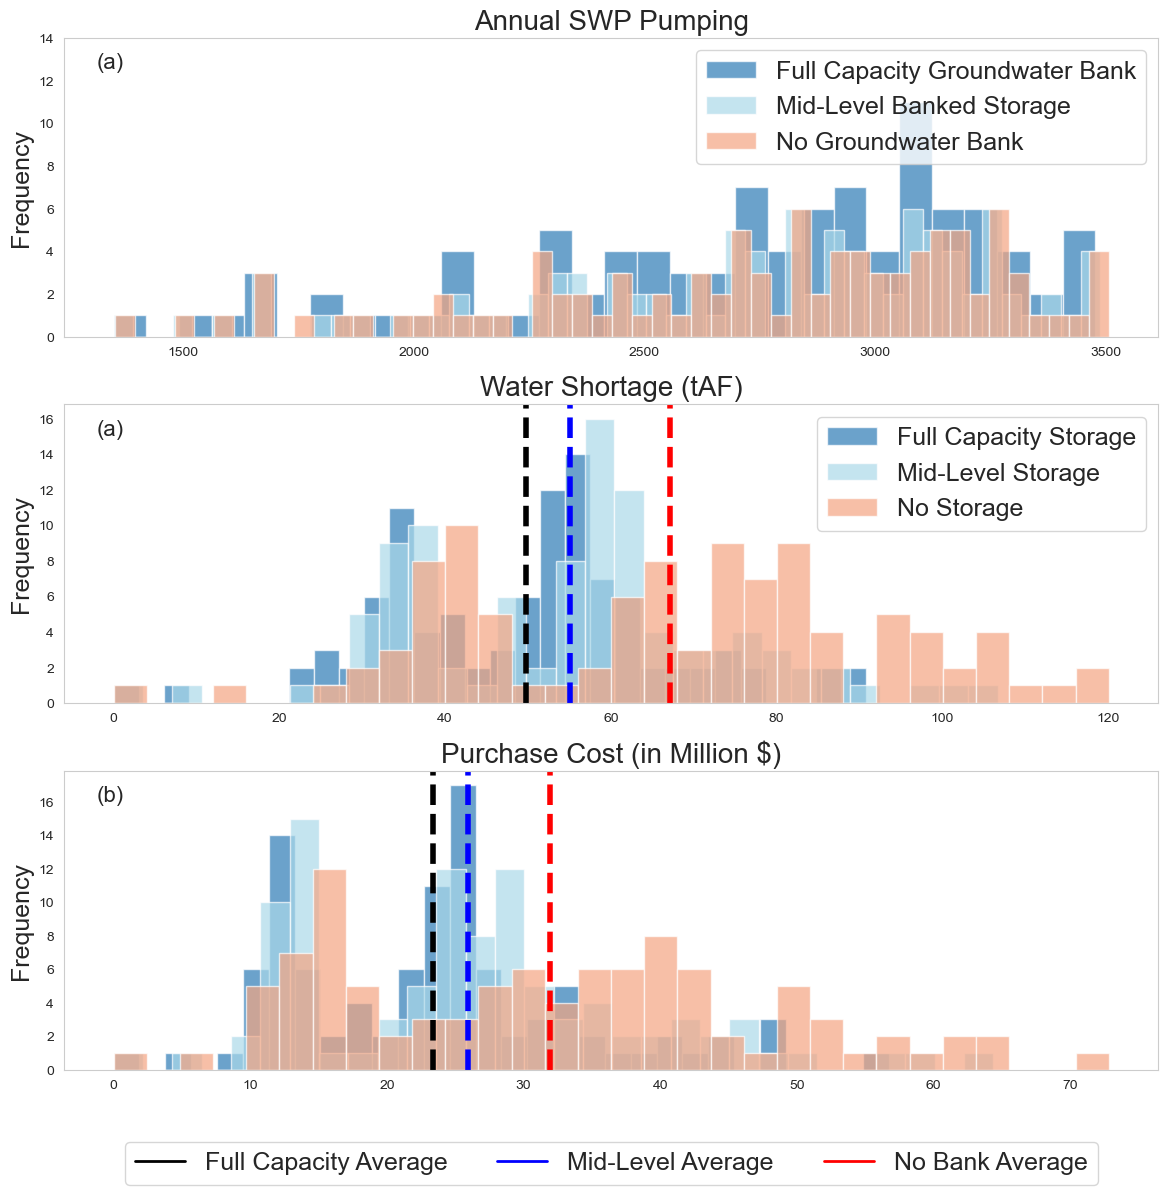

In [8]:
def calculate_annual_cost(output_folder, is_2024_format=False, scenarios=100):
    all_shortfall = []
    all_purchase_cost = []


    for i in range(1, scenarios + 1):
        if is_2024_format:
            folder_name = f"{i}_2024"
        else:
            folder_name = str(i)
        
        output_file = os.path.join(output_folder, folder_name, 'results.hdf5')

        datDaily = get_results_sensitivity_number_outside_model(output_file, '')
        list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']
        year_sim = 0
        price_dates = pd.to_datetime(['2025-06-30'])
        scenario_prices = water_price_data.loc[price_dates, f"Scenario {i}"].values
        # purchase_cost[year_sim] = adjusted_shortfall[year_sim] * scenario_prices[year_sim]

        annual_deliveries = 0
        annual_pumping = 0
        
        for wu in list_of_water_users:
            delivery_col = f'{wu}_tableA_delivery'
            pumping_col = f'{wu}_pumping'
            
            deliveries = datDaily[delivery_col].resample('AS-OCT').max()
            pumping = datDaily[pumping_col].resample('AS-OCT').sum()
            
            annual_deliveries += deliveries
            annual_pumping += pumping
        
        total_water_demand = annual_deliveries + annual_pumping
        adjusted_water_demand = np.zeros(len(total_water_demand))
        adjusted_shortfall = np.zeros(len(total_water_demand))
        purchase_cost = np.zeros(len(total_water_demand))

        year_sim = 0
        immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
        adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
        adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)
        purchase_cost[year_sim] = adjusted_shortfall[year_sim] * scenario_prices[year_sim]
        all_shortfall.append(adjusted_shortfall[year_sim])
        all_purchase_cost.append(purchase_cost[year_sim])

    return pd.DataFrame({'Shortfall': all_shortfall, 'PurchaseCost': all_purchase_cost})

# Example usage:
output_folder_banked_50 = "results/banked_50_new/"
output_folder_2024 = "results"
output_folder_banked_0 = "results/banked_0_new/"

first_year_pumping_banked_50 = extract_first_year_pumping(output_folder_banked_50)
first_year_pumping_500 = extract_first_year_pumping(output_folder_2024, is_2024_format=True)
first_year_pumping_banked_0 = extract_first_year_pumping(output_folder_banked_0)

shortfall_banked_50 = calculate_annual_cost(output_folder_banked_50)
shortfall_500 = calculate_annual_cost(output_folder_2024, is_2024_format=True)
shortfall_banked_0 = calculate_annual_cost(output_folder_banked_0)

avg_shortfall_500 = shortfall_500['Shortfall'].mean()
avg_shortfall_banked_50 = shortfall_banked_50['Shortfall'].mean()
avg_shortfall_banked_0 = shortfall_banked_0['Shortfall'].mean()

avg_cost_500 = shortfall_500['PurchaseCost'].mean() / 1000
avg_cost_banked_50 = shortfall_banked_50['PurchaseCost'].mean() / 1000
avg_cost_banked_0 = shortfall_banked_0['PurchaseCost'].mean() / 1000

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fontsize = 18
# # First subplot - Comparison of Pumping
axs[0].hist(first_year_pumping_500, bins=30, alpha=0.7, label='Full Capacity Groundwater Bank', color='#2c7bb6')
axs[0].hist(first_year_pumping_banked_50, bins=50, alpha=0.7, label='Mid-Level Banked Storage', color='#abd9e9')
axs[0].hist(first_year_pumping_banked_0, bins=50, alpha=0.7, label='No Groundwater Bank', color='#f4a582')
# axs[0].set_xlabel('Annual Pumping (First Year)', fontsize=16)
axs[0].set_ylabel('Frequency', fontsize=fontsize)
axs[0].legend(fontsize=fontsize, loc='upper right')
axs[0].set_ylim(0, 14)
axs[0].grid(False)
axs[0].set_title('Annual SWP Pumping', fontsize=20)
axs[0].text(0.03, 0.95, '(a)', transform=axs[0].transAxes, fontsize=16, verticalalignment='top')


# Second subplot - Shortage Distribution
axs[1].hist(shortfall_500['Shortfall'], bins=30, alpha=0.7,label='Full Capacity Storage',   color='#2c7bb6')
axs[1].hist(shortfall_banked_50['Shortfall'], bins=30, alpha=0.7, label='Mid-Level Storage', color='#abd9e9')
axs[1].hist(shortfall_banked_0['Shortfall'], bins=30, alpha=0.7, label='No Storage', color='#f4a582')
axs[1].set_ylabel('Frequency', fontsize=fontsize)
axs[1].grid(False)
axs[1].legend(fontsize=fontsize)
axs[1].set_title('Water Shortage (tAF)', fontsize=20)
axs[1].text(0.03, 0.95, '(a)', transform=axs[1].transAxes, fontsize=16, verticalalignment='top')
axs[1].axvline(avg_shortfall_500, color='black', linestyle='--', linewidth=4)
axs[1].axvline(avg_shortfall_banked_50, color='blue', linestyle='--', linewidth=4)
axs[1].axvline(avg_shortfall_banked_0, color='red', linestyle='--', linewidth=4)



# Third subplot - Spot Market Prices
axs[2].hist(shortfall_500['PurchaseCost']/1000, bins=30, alpha=0.7, label='Full Capacity Storage', color='#2c7bb6')
axs[2].hist(shortfall_banked_50['PurchaseCost']/1000,  bins=30, alpha=0.7,label='Mid-Level Storage', color='#abd9e9')
axs[2].hist(shortfall_banked_0['PurchaseCost']/1000,  bins=30, alpha=0.7, label='No Storage', color='#f4a582')
axs[2].set_ylabel('Frequency', fontsize=fontsize)
axs[2].set_title('Purchase Cost (in Million $)', fontsize=20)
axs[2].grid(False)
axs[2].legend(fontsize=fontsize)
axs[2].text(0.03, 0.95, '(b)', transform=axs[2].transAxes, fontsize=16, verticalalignment='top')
axs[2].axvline(avg_cost_500, color='black', linestyle='--', linewidth=4, label='Average Cost Full Capacity Bank')
axs[2].axvline(avg_cost_banked_50, color='blue', linestyle='--', linewidth=4, label='Average Cost Mid-Level Bank')
axs[2].axvline(avg_cost_banked_0, color='red', linestyle='--', linewidth=4, )

# handles, labels = axs[0].get_legend_handles_labels()
# Add a dummy Line2D to the legend to show average line indications
average_line_handle = [Line2D([0], [0], color='black', linestyle='-', linewidth=2),
                      Line2D([0], [0], color='blue', linestyle='-', linewidth=2),
                      Line2D([0], [0], color='red', linestyle='-', linewidth=2)]
average_line_labels = ['Full Capacity Average', 'Mid-Level Average', 'No Bank Average']

plt.legend(average_line_handle, average_line_labels, fontsize=fontsize, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.tight_layout()
# plt.savefig('Figure/groundwater_bank_update.png', dpi=300)
plt.show()

In [9]:
print(np.mean(first_year_pumping_500))
print(np.mean(first_year_pumping_banked_50))
print(np.mean(first_year_pumping_banked_0))

2733.7327230624155
2737.5189331720494
2744.6021092431224


# comparison of strategies

In [9]:
weighted_average_prices

array([511.0594364 , 541.241839  , 535.05810479])

In [35]:
def calculate_annual_cost(strategy, water_price_data, weighted_average_prices, price_dates, scenarios=100):
    """
    Calculate annual costs for water purchasing strategies.

    Parameters:
        strategy (str): The water purchasing strategy ('spot', 'futures', 'hybrid').
        water_price_data (pd.DataFrame): DataFrame containing water price predictions.
        weighted_average_prices (list): Weighted average prices for futures contracts.
        price_dates (list): List of dates for the pricing data.
        scenarios (int): Number of scenarios to evaluate.

    Returns:
        tuple of pd.DataFrame: Annual total cost, futures cost, spot cost, and contract fee for each scenario.
    """
    all_annual_cost = []
    all_futures_cost_component = []
    all_spot_cost_component = []
    all_contract_fee_component = []
 

    for i in range(1, scenarios + 1):
        # Simulated results retrieval
        output_file = f"results/banked_50_new/{i}/results.hdf5"
        datDaily = get_results_sensitivity_number_outside_model(output_file, '')
        validation = datDaily
        list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']

        # Get water prices for the current scenario
        scenario_prices = water_price_data.loc[price_dates, f"Scenario {i}"].values

        annual_deliveries = 0
        annual_pumping = 0

        for wu in list_of_water_users:
            delivery_col = f'{wu}_tableA_delivery'
            pumping_col = f'{wu}_pumping'

            deliveries = validation[delivery_col].resample('AS-OCT').max() 
            pumping = validation[pumping_col].resample('AS-OCT').sum()

            annual_deliveries += deliveries
            annual_pumping += pumping

        total_water_demand = annual_deliveries + annual_pumping
        n_years = len(total_water_demand)
        annual_cost = np.zeros(n_years)
        futures_cost_component = np.zeros(n_years)
        spot_cost_component = np.zeros(n_years)
        contract_fee_component = np.zeros(n_years)

        for year_sim in range(n_years):
            immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
            adjusted_water_demand = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
            adjusted_shortfall = max(adjusted_water_demand - annual_deliveries.iloc[year_sim], 0.0) * 1000


            if strategy == 'spot':
                spot_cost = adjusted_shortfall * scenario_prices[year_sim]  #spot cost is determined by actural shortfall for each scenario* spot price for each scenario
                annual_cost[year_sim] = spot_cost
                futures_cost_component[year_sim] = 0
                spot_cost_component[year_sim] = spot_cost
                contract_fee_component[year_sim] = 0
                # print(adjusted_shortfall)

            elif strategy == 'futures':
                # required_contracts = int(np.ceil(adjusted_shortfall / 10))    #future cost is determined by avg shortfall for each scenario* future price for each scenario
                required_contracts = int(np.ceil(avg_shortfall[year_sim]*1000 / 10))
                futures_coverage = required_contracts * 10
                futures_cost = futures_coverage * (weighted_average_prices[year_sim]-scenario_prices[year_sim]) + adjusted_shortfall*scenario_prices[year_sim]
            
                contract_fee = required_contracts * (2.25 * 2)
                total_futures_cost = futures_cost + contract_fee
                # print(f"Scenario {i} - Year {year_sim}: Shortfall: {adjusted_shortfall:.2f}, overpurchase:{futures_coverage-adjusted_shortfall}, contract_fee:{contract_fee:.2f}, total Cost: ${total_futures_cost:.2f}")

                annual_cost[year_sim] = total_futures_cost
                futures_cost_component[year_sim] = futures_cost
                spot_cost_component[year_sim] = 0
                contract_fee_component[year_sim] = contract_fee

            elif strategy == 'hybrid':                
                # required_contracts = int(np.ceil(adjusted_shortfall * 0.5 / 10))
                required_contracts = int(np.ceil(avg_shortfall[year_sim]*1000 * 0.5 / 10))
                futures_coverage = required_contracts * 10
                futures_cost = futures_coverage * (weighted_average_prices[year_sim]-scenario_prices[year_sim])
                contract_fee = required_contracts * (2.25 * 2)
                spot_cost = adjusted_shortfall * scenario_prices[year_sim]
                total_cost = futures_cost + spot_cost + contract_fee
                print(f"Scenario {i} - Year {year_sim}: Shortfall: {adjusted_shortfall:.2f}, required_contracts:{required_contracts}, spot price:{scenario_prices[year_sim]:.2f}, spot_cost:{spot_cost:.2f}, contract:{futures_cost:.2f}, contract_fee:{contract_fee:.2f}, Purchase Cost: ${total_cost:.2f}")
                annual_cost[year_sim] = total_cost
                futures_cost_component[year_sim] = futures_cost
                spot_cost_component[year_sim] = spot_cost
                contract_fee_component[year_sim] = contract_fee
            else:
                raise ValueError("Invalid strategy. Choose 'spot', 'futures', or 'hybrid'.")

        all_annual_cost.append(pd.DataFrame(annual_cost, columns=[f'Scenario_{i}']))
        all_futures_cost_component.append(pd.DataFrame(futures_cost_component, columns=[f'Scenario_{i}']))
        all_spot_cost_component.append(pd.DataFrame(spot_cost_component, columns=[f'Scenario_{i}']))
        all_contract_fee_component.append(pd.DataFrame(contract_fee_component, columns=[f'Scenario_{i}']))
    
    total_cost_df = pd.concat(all_annual_cost, axis=1)
    futures_cost_df = pd.concat(all_futures_cost_component, axis=1)
    spot_cost_df = pd.concat(all_spot_cost_component, axis=1)
    contract_fee_df = pd.concat(all_contract_fee_component, axis=1)

    return total_cost_df, futures_cost_df, spot_cost_df, contract_fee_df

# Usage
water_price_data = pd.read_csv("water_index_predictions.csv", parse_dates=["Date"])
water_price_data.set_index("Date", inplace=True)

price_dates = ['2025-06-30', '2026-06-30', '2027-06-30']
price_dates = pd.to_datetime(price_dates)

spot_total_costs, spot_futures_costs, spot_spot_costs, spot_contract_fees = calculate_annual_cost('spot', water_price_data, weighted_average_prices, price_dates)
futures_total_costs, futures_futures_costs, futures_spot_costs, futures_contract_fees = calculate_annual_cost('futures', water_price_data, weighted_average_prices, price_dates)
hybrid_total_costs, hybrid_futures_costs, hybrid_spot_costs, hybrid_contract_fees = calculate_annual_cost('hybrid', water_price_data, weighted_average_prices, price_dates)

Scenario 1 - Year 0: Shortfall: 62224.56, required_contracts:2752, spot price:384.76, spot_cost:23941705.18, contract:2392633.01, contract_fee:12384.00, Purchase Cost: $26346722.19
Scenario 1 - Year 1: Shortfall: 76673.28, required_contracts:3177, spot price:484.02, spot_cost:37111445.41, contract:898782.08, contract_fee:14296.50, Purchase Cost: $38024523.99
Scenario 1 - Year 2: Shortfall: 71061.64, required_contracts:3378, spot price:625.26, spot_cost:44432188.49, contract:-3900013.76, contract_fee:15201.00, Purchase Cost: $40547375.73
Scenario 2 - Year 0: Shortfall: 60903.46, required_contracts:2752, spot price:468.44, spot_cost:28529458.56, contract:89912.05, contract_fee:12384.00, Purchase Cost: $28631754.61
Scenario 2 - Year 1: Shortfall: 93083.46, required_contracts:3177, spot price:660.68, spot_cost:61498314.34, contract:-4713663.89, contract_fee:14296.50, Purchase Cost: $56798946.95
Scenario 2 - Year 2: Shortfall: 84463.44, required_contracts:3378, spot price:677.05, spot_cost:

In [47]:
mean_1 = spot_total_costs.iloc[0, :].mean()
std_1 = spot_total_costs.iloc[0, :].std()
max_1 = spot_total_costs.iloc[0, :].max()

mean_2 = futures_total_costs.iloc[0, :].mean()
std_2 = futures_total_costs.iloc[0, :].std()
max_2 = futures_total_costs.iloc[0, :].max()

mean_3 = hybrid_total_costs.iloc[0, :].mean()
std_3 = hybrid_total_costs.iloc[0, :].std()
max_3 = hybrid_total_costs.iloc[0, :].max()

# Variance calculation
variance_1 = std_1 ** 2
variance_2 = std_2 ** 2
variance_3 = std_3 ** 2

# Variance reduction percentage
variance_reduction = ((variance_1 - variance_2) / variance_1) * 100
variance_reduction_3 = ((variance_1 - variance_3) / variance_1) * 100
print( 'variance_reduction (future - spot)', variance_reduction)
print( 'variance_reduction (hybrid - spot)', variance_reduction_3)
max_reduction = ((max_1 - max_2) / max_1) * 100
max_reduction_3 = ((max_1 - max_3) / max_1) * 100
print('max_reduction (future - spot)', max_reduction)
print('max_reduction (hybrid - spot)', max_reduction_3)
median_increase = ((mean_3 - mean_1) / mean_1) * 100
median_increase_2 = ((mean_2 - mean_1) / mean_1) * 100
print('mean_increase (future - spot)', median_increase_2)
print('mean_increase (hybrid - spot)', median_increase)


variance_reduction (future - spot) 46.2879426379253
variance_reduction (hybrid - spot) 25.56580414291018
max_reduction (future - spot) 13.100362757329462
max_reduction (hybrid - spot) 6.5513716714829515
mean_increase (future - spot) 4.228878798227198
mean_increase (hybrid - spot) 2.1148236330585695


In [38]:

Spot_VaR_95 = np.percentile(spot_total_costs.iloc[0, :], 95)
future_VaR_95 = np.percentile(futures_total_costs.iloc[0, :], 95)
hybrid_VaR_95 = np.percentile(hybrid_total_costs.iloc[0, :], 95)
print(f"The 99% VaR for spot is: {Spot_VaR_95:,.2f}")
print(f"The 99% VaR for future is: {future_VaR_95:,.2f}")
print(f"The 99% VaR for hybrid is: {hybrid_VaR_95:,.2f}")
var_reduction = ((Spot_VaR_95 - hybrid_VaR_95) / Spot_VaR_95) * 100
print(f"The 99% VaR reduction (hybrid - spot): {var_reduction:.2f}%")
print(f"The 99% VaR reduction (future - spot): {((Spot_VaR_95 - future_VaR_95) / Spot_VaR_95) * 100:.2f}%")

The 99% VaR for spot is: 47,012,193.80
The 99% VaR for future is: 43,498,326.76
The 99% VaR for hybrid is: 44,996,860.94
The 99% VaR reduction (hybrid - spot): 4.29%
The 99% VaR reduction (future - spot): 7.47%


In [41]:
print(spot_total_costs.iloc[0, :].min())
print(futures_total_costs.iloc[0, :].median())
print(hybrid_total_costs.iloc[0, :].max())

0.0
27003197.21904774
60170258.50024417


In [37]:
futures_first_year_sum = hybrid_futures_costs.iloc[0, :].mean()
spot_first_year_sum = hybrid_spot_costs.iloc[0, :].mean()
contract_fee_first_year_sum = hybrid_contract_fees.iloc[0, :].mean()

# Calculate the total hybrid cost for the first year across all scenarios
total_hybrid_first_year_sum = futures_first_year_sum + spot_first_year_sum + contract_fee_first_year_sum

# Calculate the portion that each component contributes to the total hybrid cost
futures_portion = futures_first_year_sum / total_hybrid_first_year_sum
spot_portion = spot_first_year_sum / total_hybrid_first_year_sum
contract_fee_portion = contract_fee_first_year_sum / total_hybrid_first_year_sum

# Print the results
print(f"Average Futures Cost Portion: {futures_portion:.2%}")
print(f"Average Spot Cost Portion: {spot_portion:.2%}")
print(f"Average Contract Fee Portion: {contract_fee_portion:.2%}")
# , hybrid_spot_costs, hybrid_contract_fees

Average Futures Cost Portion: 2.02%
Average Spot Cost Portion: 97.93%
Average Contract Fee Portion: 0.05%


Mean cost for Strategy 1: 
Purchase water 
from spot market: $25.96 M
Median cost for Strategy 1: 
Purchase water 
from spot market: $25.63 M
Mean cost for Strategy 3: 
Hybrid: $26.51 M
Median cost for Strategy 3: 
Hybrid: $26.40 M
Mean cost for Strategy 2: 
+Future contract: $27.05 M
Median cost for Strategy 2: 
+Future contract: $27.00 M


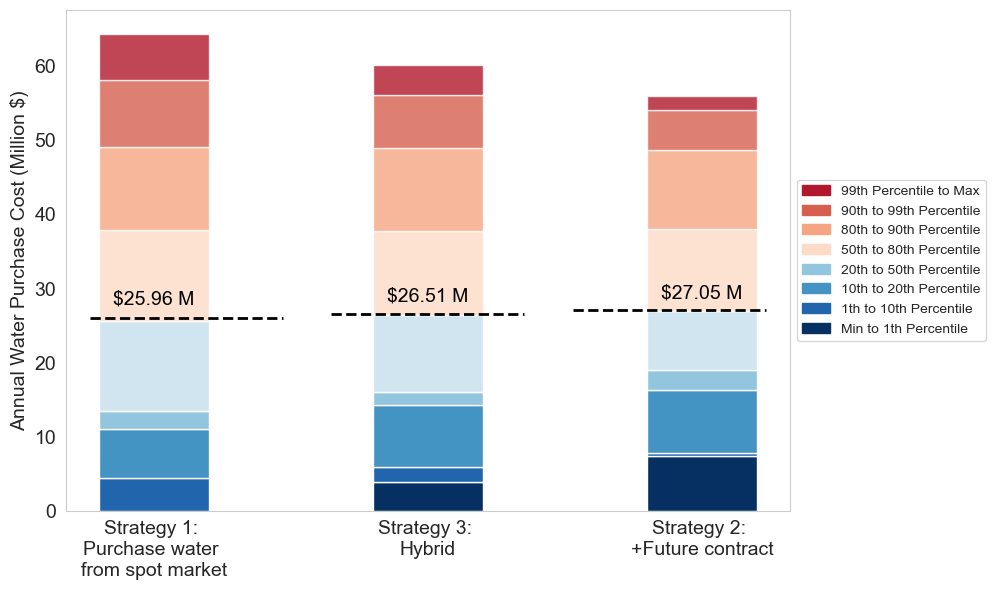

In [46]:
import matplotlib.patches as mpatches

dataframes = {
    'Strategy 1: \nPurchase water \nfrom spot market': spot_total_costs.iloc[0, :] / 1000000,
    'Strategy 3: \nHybrid': hybrid_total_costs.iloc[0, :] / 1000000,
    'Strategy 2: \n+Future contract': futures_total_costs.iloc[0, :] / 1000000,
}

fig, ax = plt.subplots(figsize=(10, 6))

# Adjusting colors to include one more for the 0 to min_value range

above_median_colors = ['#fddbc7','#f4a582','#d6604d','#b2182b', '#67001f',]  # Light to dark red
below_median_colors = ['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0',] # Ensure a color for each segment

bar_width = 0.4

for x_pos, (label, data) in enumerate(dataframes.items()):
    median_cost = data.median()
    mean_cost = data.mean()
    print(f"Mean cost for {label}: ${mean_cost:.2f} M")
    print(f"Median cost for {label}: ${median_cost:.2f} M")

    percentiles = data.quantile([0.01, 0.05, 0.20, 0.80, 0.95, 0.99]).values
    p1, p10, p20, p80, p90, p99 = sorted(percentiles)

    # Define starting and ending points
    min_value = data.min()
    max_value = data.max()

    # Calculate segment heights starting from 0
    segments = [
        min_value,  # Segment from 0 to min_value
        max(0, p1 - min_value),
        max(0, p10 - p1),
        max(0, p20 - p10),
        max(0, p80 - p20),
        max(0, p90 - p80),
        max(0, p99 - p90),
        max(0, max_value - p99)
    ]

    # Split below and above median segments
    below_segments, above_segments = [], []
    bottom = 0  # Start from 0 for the initial segment
    for height in segments:
        if bottom + height <= median_cost:
            below_segments.append(height)
        elif bottom >= median_cost:
            above_segments.append(height)
        else:  # Crosses the median
            below_segments.append(median_cost - bottom)
            above_segments.append((bottom + height) - median_cost)

        if height > 0:
            bottom += height

    # Ensure both lists are the same length for color assignment
    max_colors = max(len(above_segments), len(below_segments))
    while len(above_segments) < max_colors:
        above_segments.append(0)
    while len(below_segments) < max_colors:
        below_segments.append(0)

    # Plot below-median segments
    bottom = 0  # Start again from 0 for plotting
    for idx, height in enumerate(below_segments):
        if height > 0:
            ax.bar(x_pos, height, bottom=bottom, color=below_median_colors[idx % len(below_median_colors)], width=bar_width, alpha=1)
            bottom += height

    # Plot above-median segments
    above_segments = sorted(above_segments, reverse=True)
    for idx, height in enumerate(above_segments):
        if height > 0:
            ax.bar(x_pos, height, bottom=bottom, color=above_median_colors[idx % len(above_median_colors)], width=bar_width, alpha=0.8)
            bottom += height

    # Draw Mean line and annotate
    ax.axhline(y=mean_cost, xmin=(x_pos - bar_width / 2 + 0.3) / len(dataframes),
               xmax=(x_pos + bar_width / 2 + 0.7) / len(dataframes),
               color='black', linestyle='--', linewidth=2)
    ax.text(x_pos, mean_cost + 0.02 * max_value, f'${mean_cost:.2f} M', color='black', ha='center', va='bottom', fontsize=14)

legend_patches = [    mpatches.Patch(color=above_median_colors[3], label='99th Percentile to Max'),
            mpatches.Patch(color=above_median_colors[2], label='90th to 99th Percentile'),
                   mpatches.Patch(color=above_median_colors[1], label='80th to 90th Percentile'),
          mpatches.Patch(color=above_median_colors[0], label='50th to 80th Percentile'),        
        mpatches.Patch(color=below_median_colors[3], label='20th to 50th Percentile'),
        mpatches.Patch(color=below_median_colors[2], label='10th to 20th Percentile'),
    mpatches.Patch(color=below_median_colors[1], label='1th to 10th Percentile'),  
mpatches.Patch(color=below_median_colors[0], label='Min to 1th Percentile'),
]

ax.legend(handles=legend_patches, loc='center left',  bbox_to_anchor=(1, 0.5),fontsize=10) #

# Set labels and grid
ax.set_ylabel('Annual Water Purchase Cost (Million $)', fontsize=14)
ax.set_xticks(range(len(dataframes)))
ax.set_xticklabels(dataframes.keys(), fontsize=14)
plt.tight_layout()
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('Figure/orchard_strategy.png', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


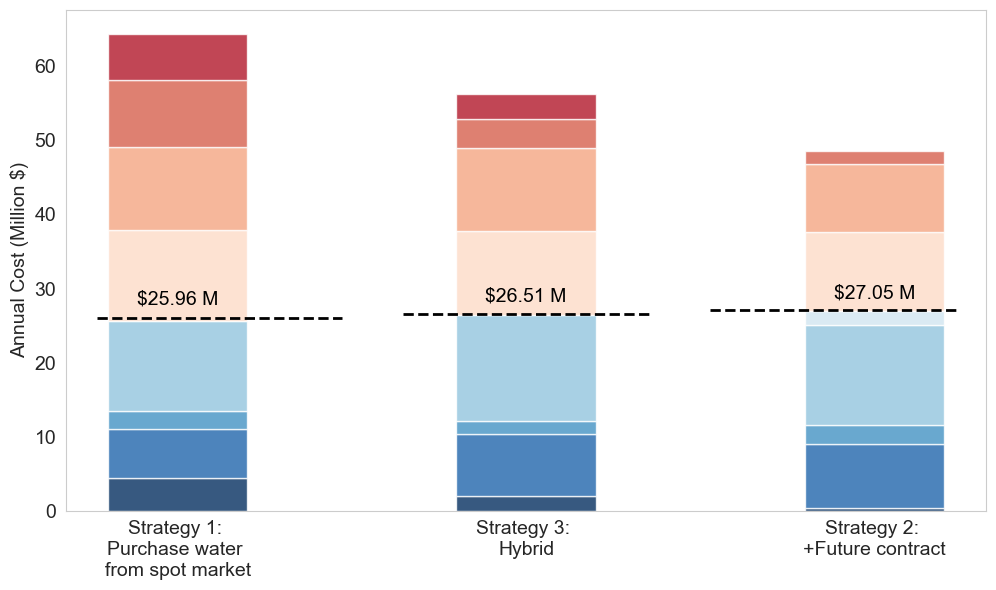

In [43]:
dataframes = {
    'Strategy 1: \nPurchase water \nfrom spot market': spot_total_costs.iloc[0, :]/1000000,
    'Strategy 3: \nHybrid': hybrid_total_costs.iloc[0, :]/1000000,
    'Strategy 2: \n+Future contract': futures_total_costs.iloc[0, :]/1000000,
}

fig, ax = plt.subplots(figsize=(10, 6))  

above_median_colors = ['#fddbc7','#f4a582','#d6604d','#b2182b', '#67001f',]  # Light to dark red
below_median_colors = ['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0',]  # Dark to light blue

bar_width = 0.4  # Adjust bar width to make columns less wide

for x_pos, (label, data) in enumerate(dataframes.items()):
    median_cost = data.median()
    mean_cost = data.mean()

    percentiles = data.quantile([0.01, 0.05, 0.20, 0.80, 0.95, 0.99]).values
    p5, p10, p20, p80, p90, p95 = sorted(percentiles)

    # Define segment heights
    segments = [
        p5 - data.min(), p10 - p5, p20 - p10, p80 - p20,
        p90 - p80, p95 - p90, data.max() - p95
    ]
    segments = [max(0, height) for height in segments]  # Ensure no negative heights

    # Split below and above median segments
    below_segments = []
    above_segments = []
    bottom = 0
    for height in segments:
        if bottom + height <= median_cost:
            below_segments.append(height)
        elif bottom >= median_cost:
            above_segments.append(height)
        else:  # Crosses the median
            below_segments.append(median_cost - bottom)
            above_segments.append(height - (median_cost - bottom))
        bottom += height
    

    # Ensure both lists have 5 colors, 1 in reserve
    max_colors = max(len(above_segments), len(below_segments))
    while len(above_segments) < max_colors:
        above_segments.append(0)
    while len(below_segments) < max_colors:
        below_segments.append(0)

    # Plot below-median segments
    bottom = 0
    for idx, height in enumerate(below_segments):
        if height > 0:
            ax.bar(x_pos, height, bottom=bottom, color=below_median_colors[idx % len(below_median_colors)], width=bar_width, alpha = 0.8)
            bottom += height

    # Plot above-median segments
    above_segments = sorted(above_segments, reverse=True)  # Reverse for darkest red at middle
    for idx, height in enumerate(above_segments):
        if height > 0:
            ax.bar(x_pos, height, bottom=bottom, color=above_median_colors[idx % len(above_median_colors)], width=bar_width, alpha = 0.8)
            bottom += height

    # Draw Median line and annotate
    ax.axhline(y=mean_cost, xmin=(x_pos - bar_width/2 +0.3) / len(dataframes), xmax=(x_pos + bar_width/2 +0.7) / len(dataframes),
               color='black', linestyle='--', linewidth=2)
    ax.text(x_pos, mean_cost + 0.02 * data.max(), f'${mean_cost:.2f} M', color='black', ha='center', va='bottom', fontsize=14)

# Set labels and grid
ax.set_ylabel('Annual Cost (Million $)', fontsize=14)
ax.set_xticks(range(len(dataframes)))
ax.set_xticklabels(dataframes.keys(), fontsize=14)
plt.tight_layout()
# plt.tick_params(left=False) 
plt.yticks(fontsize=14)  
ax.legend().remove()  # Removing the legend if not needed, change if required
plt.grid(False)
# plt.savefig('Figure/water_strategy_bank50.png', dpi=300)
plt.show()